In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create `Field2D` class

Simplest field possible, an $n\times n$ grid that calculates distance using the Pythagorean theorem.  
Use this as a blueprint for more complicated (network-based) classes.

In [2]:
class Field2D():
    # create a 2D grid to find weights and distances on

    cost_est = None
    weights = None 
    res = 1

    def __init__(self, xsize, ysize, init_cost, res=1):
        '''
        initialize cost estimate grid and weight grid
        '''
        # TODO: tweakable resolution?
        self.cost_est = np.ones([xsize, ysize])*init_cost
        self.weights = np.ones([xsize, ysize])
        self.res = res
    
    def get_dist(self, loc1, loc2):
        '''
        get distance between two locs
        '''
        return ((loc2[0] - loc1[0])**2 + (loc2[1] - loc1[1])**2)**(1/2)
    
    def cmask(self, loc, radius):
        '''
        get all IDs within a given radius (after normalization to indices) of loc
        '''
        radius_normalized = radius/self.res
        a,b = loc
        nx,ny = self.weights.shape
        y,x = np.ogrid[-a:nx-a,-b:ny-b]
        x,y = np.where(x*x + y*y <= radius_normalized*radius_normalized)
        return set([(x[i],y[i]) for i in range(len(x))])
    
    def set_loc(self, loc, cost_est=None, weight=None):
        '''
        set the cost estimate and weight at a location to new values
        '''
        if cost_est:
            self.cost_est[loc] = cost_est
        if weight:
            self.weights[loc] = weight

## test `Field2D`

Instantiate a `Field2D` and verify that the distance function is working as intended.

In [3]:
testfield = Field2D(10,10,20)
print(testfield.get_dist((0,0),(0,10)))
print(testfield.get_dist((0,0),(10,0)))
print(testfield.get_dist((0,0),(10,10)))

10.0
10.0
14.142135623730951


# Create `BackhaulEstimator`

Works with any class that follows the `Field2D` prototype.

Given a newly resolved shipping request containing (origin coordinates `loc1`, destination coordinates `loc2`, offer price `price`, and whether or not the request was accepted `accepted`), the estimate and weight algorithm proceeds as follows:
1. Estimate `cost`, the portion of `price` allocated to traveling to `loc1` or from `loc2` by subtracting the cost to travel between `loc1` and `loc2` and dividing by 2.
    1. If `cost` is less than zero, set to zero in order not to break subsequent steps with negative numbers.
2. Calculate area of effect `radius` by tranforming `cost` to distance units by some constant factor `__b`.
3. Identify the set of coordinates within 1 `radius` distance of `loc1` or `loc2` as `inner` and the set of coordinates outside of 1 `radius` but within 2 `radius` as `outer`. Compile corresponding distances outside of 1 `radius` for every coordinate in `outer`, normalized to between `[0,1]`.
4. For every coordinate `loc` in `inner` or `outer`, update the cost estimate and weight if necessary.
    1. There are four situations that determine if and how the cost estimates and weights are updated that depend on the current cost estimate `c_hat`, observed `cost`, and `accepted`:
        1. If `accepted` and `cost` is less than `c_hat` (i.e., the request was accepted even though the price offered was less than our estimate), move our current estimate toward `cost` according to the current weight `w`. $\text{cost_est} = w \times \text{cost} + (1-w)\times\text{c_hat}$. Update `w` using the less aggressive method `weight_update`.
        2. If `accepted` and `cost` is greater than `c_hat` (i.e., the request was accepted and the price offered was more than our estimate), don't update the `cost_est` since this is expected behavior but still update `w` using the less aggressive method `weight_update`.
        3. If not `accepted` and `cost` is less than `c_hat` (i.e. the request was rejected and the price offered was less than our estimate), do nothing since this is expected behavior. _(TODO: why are cases 3 and 4 treated differently w.r.t. weights even though both are expected behavior?)_
        4. If not `accepted` and `cost` is greater than `c_hat` (i.e., the request was rejected even though the price offered was more than our estimate), update the `cost_est` since this is expected behavior but still update `w` using the less aggressive method `weight_update`.
    2. If the coordinate is in `outer` and is having its cost updated, reduce update by further moving estimate back toward `c_hat` according to the normalized distance of coordinate outside of inner circle `d` $\in [0,1]$. $\text{cost_est} = (1-d) \times \text{cost_est} + (d)\times\text{c_hat}$

In [4]:
class BackhaulEstimator:
    '''
    create a prototype that can handle distances in either a 2D grid or a road network
    concrete implementations of Field need to follow the prototype set by the `Field2D` class
    '''

    __b = 10 # base cost per mile in $/mi

    def __init__(self, 
                 field, 
                 weight_fcn=(lambda w,d: w/(1+.001*(1-d))), 
                 weight_fcn_aggressive=(lambda w,d: w/(1+.001*(1-d))),
                 update_on_expected_behavior=True):
        '''
        pass an object following the Field2D prototype
        weight functions decide how field weights will be updated when new information is received
        '''
        self.field = field
        self.weight_fcn = weight_fcn
        self.weight_fcn_aggressive = weight_fcn_aggressive
        self.update_on_expected_behavior = update_on_expected_behavior
    
    def __get_radial_area(self, loc, radius):
        '''
        get list of indices that can be used to identify grid locations/nodes and their distance to the loc
        '''

        # get mask
        inner = self.field.cmask(loc, radius)
#         outer = self.field.cmask(loc, 2*radius).difference(inner)
        
        # create dict for outer points of their normalized distance from the circle
        inner_dists = {k: np.nan_to_num((self.field.get_dist(loc, k))/radius) for k in inner}
#         outer_dists = {k: (self.field.get_dist(loc, k) - radius)/radius for k in outer}
        
        return inner, inner_dists
#         return inner, outer, outer_dists
    
    def __new_cost_est(self, cost, c_hat, w, d):
        '''
        convenience function to calculate new cost estimate
        '''
        # initial cost estimate based on mixing current cost estimate and new observed cost based on weight
        # note weights are within [0,1]
        cost_est = (w)*cost + (1-w)*c_hat
        if d > 0: # decay influence of new observed cost outside of inner circle
            cost_est = (1-d)*cost_est + d*c_hat
        # this is equivalent to the following
        # cost_est = (1-d)*(w)*cost + (1 - w + d*w)*c_hat
        
        return cost_est
        
    
    def __update_index(self, loc, cost, accepted, d=0):
        '''
        update estimated cost and weight at a specific index based on a resolved request's cost and acceptance status 
        '''
        c_hat = self.field.cost_est[loc]
        w = self.field.weights[loc]
        
        underestimate = cost > c_hat
        
        if accepted and (not underestimate): # case a
            # estimate overshot, update accordingly
            cost_est = self.__new_cost_est(cost, c_hat, w, d)
            weight = self.weight_fcn(w,d)
            self.field.set_loc(loc, cost_est, weight)
        
        if accepted and underestimate: # case b
            # expected behavior, update weights or just do nothing
            if self.update_on_expected_behavior:
                weight = self.weight_fcn(w,d)
                self.field.set_loc(loc, None, weight)
        
        if (not accepted) and (not underestimate): # case c
            # expected behavior, update weights or just do nothing
            if self.update_on_expected_behavior:
                weight = self.weight_fcn(w,d)
                self.field.set_loc(loc, None, weight)
                
        if (not accepted) and underestimate: # case d
            # estimate undershot, update accordingly
            cost_est = self.__new_cost_est(cost, c_hat, w, d)
            weight = self.weight_fcn(w,d)
            self.field.set_loc(loc, cost_est, weight)
        
        
#         # move estimate toward observed cost if it contains more information
#         if accepted or (cost > c_hat):
#             w = self.field.weights[loc]

#     #         # calc alpha coeff to decay effect outside of inner area.
#     #         # note d is normalized distance outside of inner circle from [0,1]
#     #         alpha = d #(d*self.__b/cost)
        
#             if accepted and (cost > c_hat): # this is expected behavior so we don't update the cost estimate
#                 cost_est = c_hat
#             else:
#                 # initial cost estimate based on mixing current cost estimate and new observed cost based on weight
#                 # note weights are within [0,1]
#                 cost_est = (w)*cost + (1-w)*c_hat
#                 if d > 0: # decay influence of new observed cost outside of inner circle
#                     cost_est = (1-d)*cost_est + d*c_hat
#                 # this is equivalent to the following
#                 # cost_est = (1-d)*(w)*cost + (1 - w + d*w)*c_hat

#             # make updated cost estimate stickier than before
#             if accepted:
#                 weight = self.weight_fcn(self.field.weights[loc],d)
#             elif (cost > c_hat):
#                 weight = self.weight_fcn_aggressive(self.field.weights[loc],d)

#             self.field.set_loc(loc, cost_est, weight)
    
    def __get_rec_range(self, loc1, loc2):
        '''
        recommend pricing range that trades off between likelihood of acceptance and 
        gathering additional information about area of study. returns length 2 array.
        '''
        # TODO
        range = [0,0]
        return range

    def get_cost_est(self, loc1, loc2):
        '''
        calculate estimated cost of delivery with cost of getting to loc1, leaving loc2, and travel dist
        '''        
        # TODO: consider factoring in cost of getting paid to get closer to depot(?)        
        return self.field.cost_est[loc1] + self.field.cost_est[loc2] + self.field.get_dist(loc1, loc2)*self.__b

    def update_est(self, loc1, loc2, price, accepted):
        '''
        update estimates in areas affected by new offer resolution
        '''
        cost = (price - self.__b*self.field.get_dist(loc1, loc2))/2
        if cost < 0:
            # undervalued cost, breaks equation.
#             print(self.__b*self.field.get_dist(loc1, loc2))
#             print('cost {} shouldn\'t be less than zero. setting cost to 0.'.format(cost))
            cost = 0
        
        # get radial areas around loc1 and loc2 and reconcile the overlap
        radius = cost/self.__b
        inner1, inner_dists1 = self.__get_radial_area(loc1, radius)
        inner2, inner_dists2 = self.__get_radial_area(loc2, radius)
#         inner1, outer1, outer_dists1 = self.__get_radial_area(loc1, radius)
#         inner2, outer2, outer_dists2 = self.__get_radial_area(loc2, radius)
        inner1.update(inner2)
        inner = inner1
#         outer1.update(outer2)
#         outer = outer1
#         outer.difference_update(inner)

        # merge outer_dists dictionaries, removing entries in inner and taking minimum dist in case of overlap
        inner_dists = {}
        for k in inner:
            dists = []
            if k in inner_dists1:
                dists.append(inner_dists1[k])
            if k in inner_dists2:
                dists.append(inner_dists2[k])
            inner_dists[k] = min(dists)

#         # merge outer_dists dictionaries, removing entries in inner and taking minimum dist in case of overlap
#         outer_dists = {}
#         for k in outer:
#             dists = []
#             if k in outer_dists1:
#                 dists.append(outer_dists1[k])
#             if k in outer_dists2:
#                 dists.append(outer_dists2[k])
#             outer_dists[k] = min(dists)

        # update cost estimate and weights in affected areas
        for loc in inner:
            self.__update_index(loc, cost, accepted, d=inner_dists[loc])
            
#         # TODO: remove after debugging
#         # plot weight fields after updating inner section 
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after inner update')
#         plt.show()

#         for loc in outer:
#             self.__update_index(loc, cost, accepted, d=outer_dists[loc])

#         # TODO: remove after debugging
#         # plot weight fields after updating inner and outer sections
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after full update')
#         plt.show()
    
    def get_recommended_cost(self, loc1, loc2):
        '''
        convenience function to yield a single price from the estimate and info range
        aiming to maximize the likelihood of a match first, then info gathering
        if est in range, return est
        if est below range, return est
        if est above range, return range high
        '''
        pass

        est = self.get_cost_est(loc1, loc2)
        rng = self.__get_rec_range(loc1, loc2)

        if est < rng[1]:
            return est
        else:
            return rng[1]

## Testing `BackhaulEstimator`

Start by instantiating the test field and plotting the (supposedly empty) field and an assumption (for testing purposes) that our truck is moving from (9,9) to (0,0) originally.

Turns out choosing how to instantiate the field's initial cost estimate matters a lot.

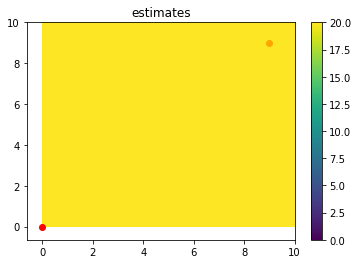

In [5]:
testfield = Field2D(10,10,20)
be = BackhaulEstimator(testfield)

# convenience function for plotting
def plot_field(field, og, dt, estimates=True, vmin=0, vmax=100):
    a=plt.pcolor(field.cost_est if estimates else field.weights, vmin=vmin, vmax=vmax)
    plt.colorbar(a)
    plt.scatter(og[0], og[1], color='orange')
    plt.scatter(dt[0], dt[1], color='red')
    plt.title('estimates' if estimates else 'weights')
    plt.show()
plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Update with our first request, an accepted movement from (4,5) to (5,4) at 50 revenue units.  
Sanity check both contour plot and raw values for both cost estimates and weights.

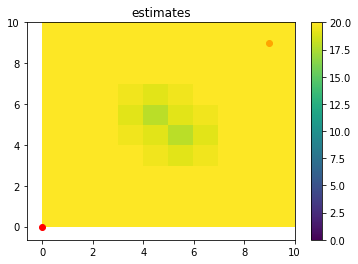

In [6]:
be.update_est((4,5),(5,4),50,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

In [7]:
print(testfield.cost_est)

[[20.         20.         20.         20.         20.         20.
  20.         20.         20.         20.        ]
 [20.         20.         20.         20.         20.         20.
  20.         20.         20.         20.        ]
 [20.         20.         20.         20.         20.         20.
  20.         20.         20.         20.        ]
 [20.         20.         20.         20.         19.56256667 19.08408621
  19.56256667 20.         20.         20.        ]
 [20.         20.         20.         19.56256667 19.08408621 17.92893219
  19.08408621 20.         20.         20.        ]
 [20.         20.         20.         19.08408621 17.92893219 19.08408621
  19.56256667 20.         20.         20.        ]
 [20.         20.         20.         19.56256667 19.08408621 19.56256667
  20.         20.         20.         20.        ]
 [20.         20.         20.         20.         20.         20.
  20.         20.         20.         20.        ]
 [20.         20.         20.   

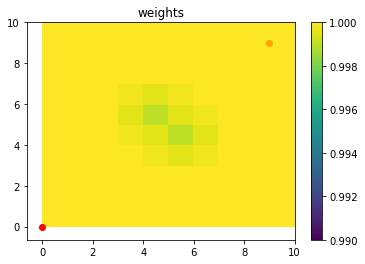

In [8]:
plot_field(testfield, og=(9,9), dt=(0,0), estimates=False, vmin=0.99, vmax=1)

In [9]:
print(testfield.weights)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         0.99978883 0.99955795
  0.99978883 1.         1.         1.        ]
 [1.         1.         1.         0.99978883 0.99955795 0.999001
  0.99955795 1.         1.         1.        ]
 [1.         1.         1.         0.99955795 0.999001   0.99955795
  0.99978883 1.         1.         1.        ]
 [1.         1.         1.         0.99978883 0.99955795 0.99978883
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.   

Add a few more movements based on the idea that the trucks original origin and destination are around the top right (9,9) and bottom left (0,0), respectively.

First, a path longer, perpendicular to, and cheaper than the first movement that aligns with the original origin/destination path.

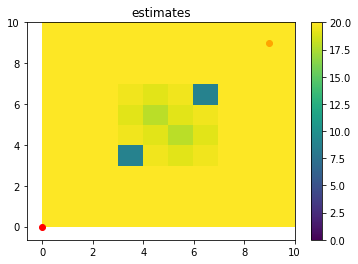

In [10]:
be.update_est((6,6),(3,3),60,True)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Next a rejected request.

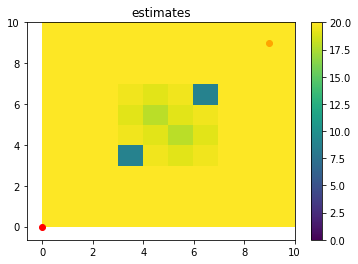

In [11]:
be.update_est((6,3),(3,6),50,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

Finally a long and expensive rejected request intended to raise estimated costs on the fringe. It doesn't do much since we initialized the weight grid high already.

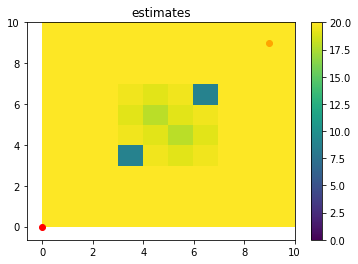

In [12]:
be.update_est((1,8),(8,1),130,False)

plot_field(testfield, og=(9,9), dt=(0,0), vmin=0, vmax=20)

## Randomized, programmatic testing

Now that we've verified that custom-drawn paths work, let's design a testing procedure with random elements that can create randomized requests.

Procedure as follows:
1. Create a square `Field2D` of some `size` and initial cost equivalent to traveling the length `size`, as well as a corresponding `BackhaulEstimator` with some `weight_fcn` and `weight_fcn_aggressive`. Initialize current origin `og` to input `org`.
2. Start accepted requests counter `i` and consequetive rejected requests counter `r` at 0. While `i` is less than input `n`,
    1. Calculate the cost `curcost` to get from current origin `og` to the global endpoint, the input `depot`.
    2. Randomly generate shipping request origin and destination coordinates `rog` and `rdt` from the uniform distribution between `[0,size]`.
    3. Calculate `mincost`, the bare cost to travel from `rog` to `rdt` without accounting for getting from current `og` to `rog` or `rdt` to `depot`.
    4. Generate a price offer `rev` for the request by taking `mincost` and adding a random term scaled between a minimum and maximum distance `random_range` specified by an input
    5. Calculate the actual cost of fulfilling the shipping request by taking `mincost` and adding the cost of traveling from `og` to `rog` and from `rdt` to `depot`.
    6. Check if the carrier will profit from accepting the request, i.e. if the revenue `rev` is greater than the additional cost of accepting the request `ofcost - curcost`.
        1. If so, accept the request, update cost estimates and weights accordingly, and increment the accepted requests counter `i`.
        2. If not, reject the request, update cost estimates and weights accordingly, and increment the consecutive rejected requests counter `r`.
            1. If `r` has reached input `rlim`, reset `r=0` and `og` to the original origin `ogorg`.
    7. For every input `progress_plot_interval` number of requests and when the rejected requests counter `r` is at zero, output a progress plot of the current weight estimates.

Estimated, offered, real cost 540.356688476182 135.9177987435464 276.21455285245105
rejected (15, 0) (14, 14) 135.9177987435464
Estimated, offered, real cost 498.488578017961 150.2217784351741 223.5003915515839
rejected (5, 15) (14, 19) 150.2217784351741
Estimated, offered, real cost 464.0312423743285 48.68457985864741 83.32056425567373
rejected (10, 10) (14, 5) 48.68457985864741
resetting OD


/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


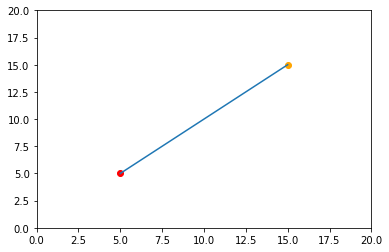

Estimated, offered, real cost 530.384048104053 175.2519007712899 235.94987078127474
rejected (10, 2) (9, 15) 175.2519007712899
Estimated, offered, real cost 564.0121946685673 173.5671804309968 229.31622163726695
rejected (14, 8) (1, 18) 173.5671804309968
Estimated, offered, real cost 538.924439894498 194.2840644979887 275.8510471253875
rejected (1, 5) (13, 12) 194.2840644979887
resetting OD


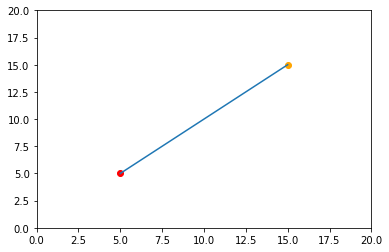

Estimated, offered, real cost 444.7213595499958 144.6390320596472 81.52379641357447
accepted (19, 11) (17, 7) 144.6390320596472


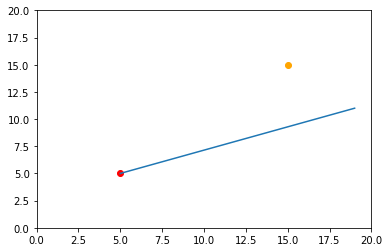

Estimated, offered, real cost 594.164878389476 233.1765247989906 403.1583655475968
rejected (1, 7) (17, 18) 233.1765247989906
Estimated, offered, real cost 444.7213595499958 20.79965344465335 98.4614101873575
rejected (4, 3) (2, 7) 20.79965344465335
Estimated, offered, real cost 422.3606797749979 113.81218944403918 71.27627391389635
accepted (3, 11) (4, 9) 113.81218944403918


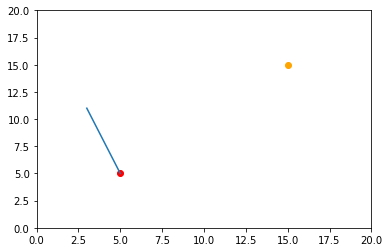

Estimated, offered, real cost 511.8229297948917 236.9108552238722 305.09386316348326
rejected (17, 13) (5, 0) 236.9108552238722
resetting OD


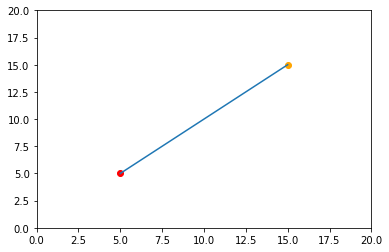

Estimated, offered, real cost 596.977156035922 147.876999962328 253.2253763887943
rejected (4, 19) (12, 1) 147.876999962328
Estimated, offered, real cost 330.15497840139346 57.668092076115954 112.97181747253569
rejected (6, 10) (2, 14) 57.668092076115954
Estimated, offered, real cost 520.415945787923 93.54948686707235 153.71594910060924
rejected (17, 19) (5, 18) 93.54948686707235
resetting OD


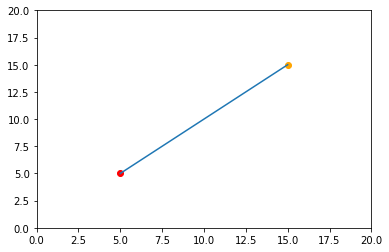

Estimated, offered, real cost 419.2756771564074 226.26436406709428 157.8625265345317
accepted (18, 11) (5, 16) 226.26436406709428


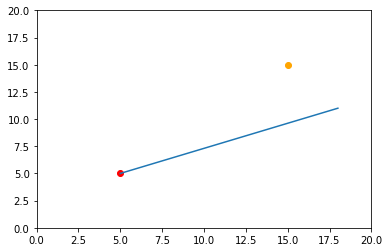

Estimated, offered, real cost 421.1685114638867 121.09591087979885 207.79417874934484
rejected (6, 8) (14, 14) 121.09591087979885
Estimated, offered, real cost 441.2310562561766 41.095828832417396 56.77791986546512
rejected (11, 7) (10, 11) 41.095828832417396
Estimated, offered, real cost 414.87606909246597 160.92299376552535 134.4700199695705
accepted (18, 3) (5, 10) 160.92299376552535


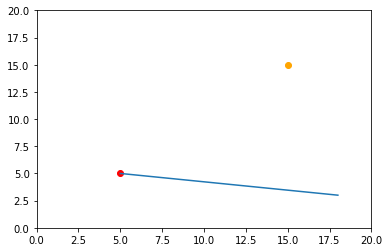

Estimated, offered, real cost 419.49996376757656 98.16521232242143 159.3393360911504
rejected (7, 8) (10, 14) 98.16521232242143
resetting OD


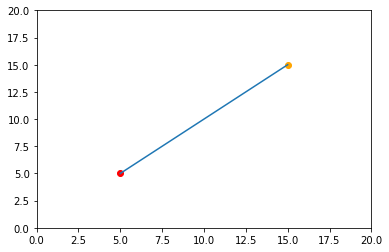

Estimated, offered, real cost 451.86110951903675 119.11999759371939 90.79798842560294
accepted (15, 15) (17, 4) 119.11999759371939


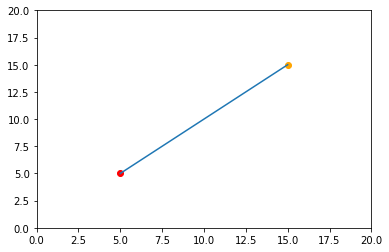

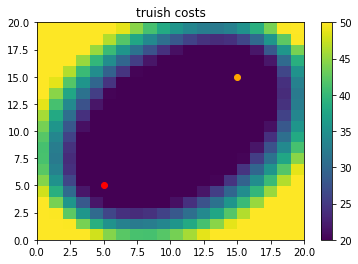

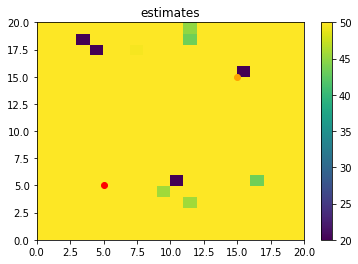

In [13]:
def big_tester(size, n, rlim, ogorg, depot, random_range, weight_fcn, weight_fcn_aggressive, vmin, vmax, update_on_expected_behavior=True, log=False, progress_plot_interval=None, debug=False):
    '''
    randomly generate resolved requests and feed them to a BackhaulEstimator with a size^2 Field2Duntil we hit n requests accepted.
    size: length of each edge of the Field2D grid
    n: number of requests to accept before ending the test session
    rlim: number of consecutive requests rejected until the origin is reset to ogorg 
    ogorg: carrier's original origin coordinates
    depot: carrier's depot (final destination)
    random_range: [min, max] additional value (in distance units, to be scaled by a distance-to-cost factor) added to the cost of fulfilling a shipping request (with considering travel to/away from the request)
    weight_fcn, weight_fcn_aggressive: weight updating functions provided to BackhaulEstimator
    progress_plot_interval: how often to output a current-estimate contour plot, by units of requests accepted
    debug: whether or not to show progress messages and plots
    '''

    testfield = Field2D(size,size,size*BackhaulEstimator._BackhaulEstimator__b)
    be = BackhaulEstimator(
            testfield, 
            weight_fcn = weight_fcn, 
            weight_fcn_aggressive = weight_fcn_aggressive,
            update_on_expected_behavior = update_on_expected_behavior
            )
    
    # estimate true cost of each coordinate
    # only calculates cost relative to deviation from the original origin and depot 
    truish_costs = testfield.cost_est.copy()
    og_distance = testfield.get_dist(ogorg, depot)
    for i in range(0,size): # TODO: replace with matrix calculation
        for j in range(0,size):
            coord = (i,j)
            # average of (distance to travel from origin to coord, distance to travel from coord to depot - distance from origin to depot)
            truish_costs[i,j] = .5*(testfield.get_dist(ogorg, coord) + (testfield.get_dist(coord, depot) - og_distance) )*be._BackhaulEstimator__b
    
    total_rmse = []

    i = 0 # requests accepted
    r = 0 # requests rejected since last reassignment

    og = ogorg
    
    plotted = False # flag to prevent duplicate plots
    est_updated = False # flag for if we need to do RMSE checks after the estimate has been updated

    while i < n:
        
        # flag for estimation update
        if est_updated:
            # update rmse lists
            rmse = np.sqrt((truish_costs - testfield.cost_est)**2)
            total_rmse.append(np.sum(np.sum(rmse)))
            
            # check for oscillation. if found, break while loop.
            horizon = max(len(total_rmse)//10, 10*(r+1)) # check the larger of the last 10% of updates or the last 10 resets, assuming all reset without updating
            if np.all(total_rmse[-1*horizon:] > np.min(total_rmse)):
                break
            
            est_updated = False
        
        # despite debug, plot progress every progress_plot_interval accepted requests if the rejection counter has reset
        if progress_plot_interval and (i%progress_plot_interval == 0) and (not plotted) and i>0:
            f, (est, err) = plt.subplots(1, 2)
            f.set_size_inches(10, 4)
            
            # plot cost estimates
            if log:
                a = est.pcolor(testfield.cost_est, norm=LogNorm(vmin=vmin, vmax=vmax))
            else:
                a = est.pcolor(testfield.cost_est, vmin=vmin, vmax=vmax)
            f.colorbar(a, ax=est)
            est.scatter(ogorg[0], ogorg[1], color='orange')
            est.scatter(depot[0], depot[1], color='red')
            est.set_title('estimates at i={}'.format(i))
            
            # print total RMSE and plot
            print('Total RMSE: {}'.format(total_rmse[-1]))
            b = err.pcolor(rmse, vmin=vmin, vmax=vmax)
            f.colorbar(b, ax=err)
            err.scatter(ogorg[0], ogorg[1], color='orange')
            err.scatter(depot[0], depot[1], color='red')
            err.set_title('RMSE at i={}'.format(i))
            plt.show()
            
            plotted = True # we've plotted so we don't need to replot unless something changes

        # calc current cost to return to depot
        curcost = testfield.get_dist(og, depot)*be._BackhaulEstimator__b

        # randomly generate an OD pair
        rog = (np.random.randint(size), np.random.randint(size))
        rdt = (np.random.randint(size), np.random.randint(size))

        # calculate minimum cost of transporting
        mincost = testfield.get_dist(rog, rdt)*be._BackhaulEstimator__b

        # add random addtl revenue to cover cost of travel, with minimum offer being 0
        rev = max(0, mincost + (np.random.rand()*(random_range[1]-random_range[0]) + random_range[0])*be._BackhaulEstimator__b)

        # calc true cost to fulfill request then return to depot
        ofcost = (testfield.get_dist(og, rog) + testfield.get_dist(rog, rdt) + testfield.get_dist(rdt, depot))*be._BackhaulEstimator__b

        # est cost, offered cost, real cost 
        if debug:
            print('Estimated, offered, real cost', be.get_cost_est(rog, rdt), rev, ofcost-curcost)

        # check if there's profit for carrier
        if rev > (ofcost - curcost):
            # if so, fulfill request and change current origin
            if debug:
                print('accepted', rog, rdt, rev)
            be.update_est(rog, rdt, rev, True)
            est_updated = True
            og = rog
            i += 1
            
            plotted = False # map has changed so plot it 

            if debug:
                # plot change to od pair
                plt.plot([og[0], depot[0]], [og[1], depot[1]])
                plt.scatter(ogorg[0], ogorg[1], color='orange')
                plt.scatter(depot[0], depot[1], color='red')
                plt.ylim(0,size)
                plt.xlim(0,size)
                plt.show()
                
        else: # reject request
            if debug:
                print('rejected', rog, rdt, rev)
            be.update_est(rog, rdt, rev, False)
            est_updated = True
            r += 1

            # reset trajectory if there have been more than 10 rejected requests
            if r >= rlim:
                r = 0
                og = ogorg
                
                if debug:
                    print('resetting OD')
                    # plot graph after return to original OD pair
                    plt.plot([og[0], depot[0]], [og[1], depot[1]])
                    plt.scatter(ogorg[0], ogorg[1], color='orange')
                    plt.scatter(depot[0], depot[1], color='red')
                    plt.ylim(0,size)
                    plt.xlim(0,size)
                    plt.show()
    
    # plot truish costs to compare
    a = plt.pcolor(truish_costs, vmin=vmin, vmax=vmax)
    plt.colorbar(a)
    plt.scatter(ogorg[0], ogorg[1], color='orange')
    plt.scatter(depot[0], depot[1], color='red')
    plt.title('truish costs')
    plt.show()
    
    if progress_plot_interval and i>0:
        # plot total RMSE over iterations
        plt.plot(np.arange(0, len(total_rmse)), np.log(total_rmse))
        plt.title('log(RMSE) vs. updates')
        plt.xlabel('Updates (not acceptances)')
        plt.ylabel('log(RMSE)')
        plt.show()
    
    return testfield

size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

tf = big_tester(size, 5, 3, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, debug=True)
plot_field(
    tf, 
    og=ogorg, 
    dt=depot, 
    vmin=20, 
    vmax=50)

Debug mode verifies that at least our costing and origin/destination reassignment is working as intended.

# The real test

We're defaulting to weight functions of the form $$w' = \frac{w}{1 + (1-d)\times 10^{c}}$$ where $d$ is the normalized distance outside the circle (for coordinates in `outer`) and $c$ is $-4$ for normal weight updates and $-3$ for aggressive ones.

We're randomizing the revenue above the bare cost to travel from request origin to request origin between $[-\frac{1}{4},\frac{1}{2}]$ the size of the field for two reasons:
1. minimum is negative to account for the possibility of the request to align with the direction of travel from original origin and destination,
2. maximum is $\frac{1}{2}$ since it seems like generally the maximum cost to travel from any arbitrary origin to any arbitrary destination plus the reverse. (Really it just felt right.)

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


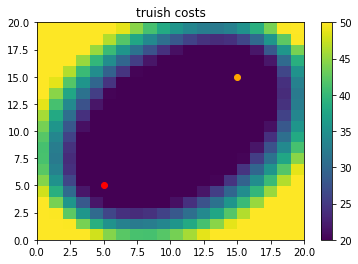

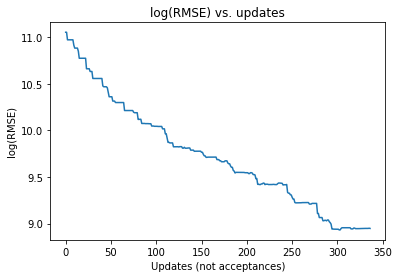

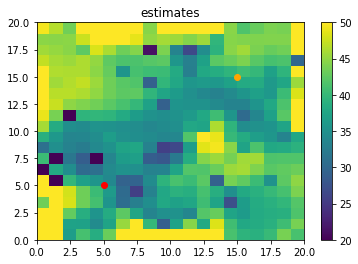

In [14]:
size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=500)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

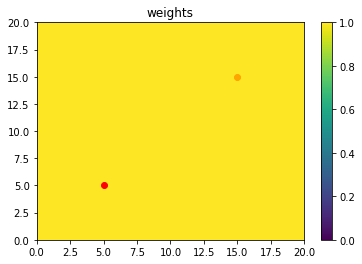

In [15]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

We notice that most cains were made at the very beginning. Let's dig deeper there.

### Higher resolution at the beginning of training

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Total RMSE: 12453.961330081434


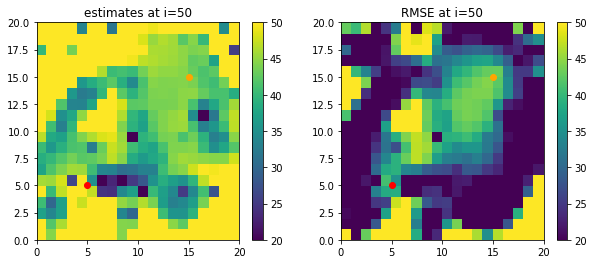

Total RMSE: 8002.458307495188


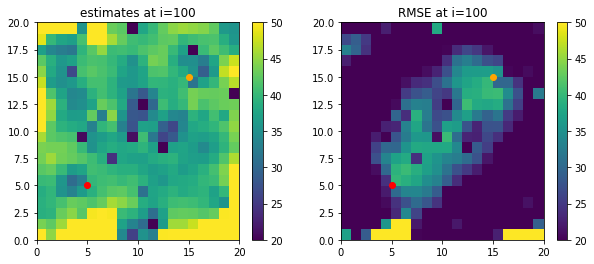

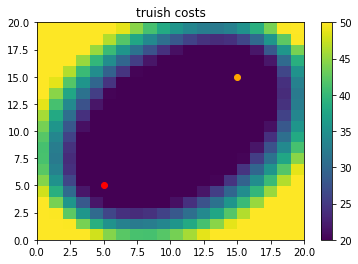

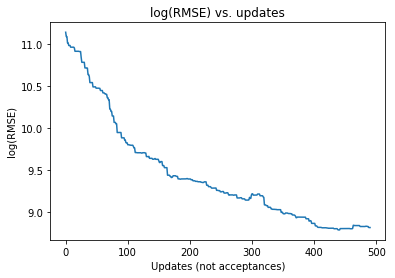

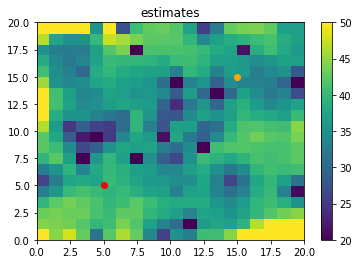

In [16]:
field = big_tester(size, 501, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

Even deeper!

### Even higher resolution at the beginning of training

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Total RMSE: 54035.390744823875


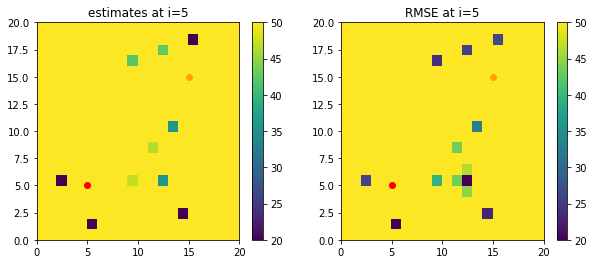

Total RMSE: 42989.91521748259


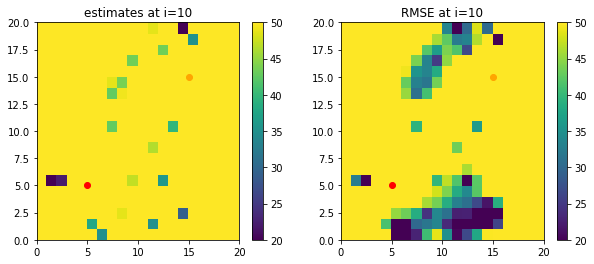

Total RMSE: 33277.211987480325


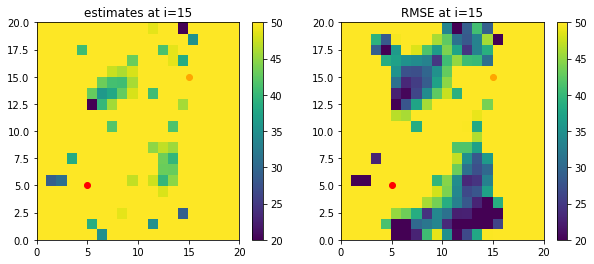

Total RMSE: 28757.67928048803


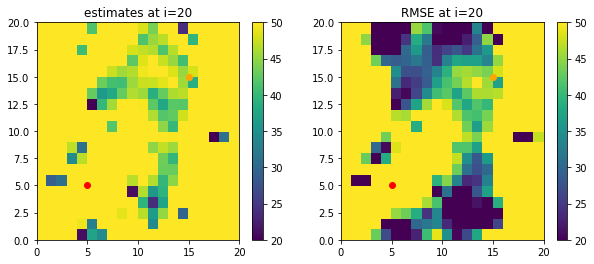

Total RMSE: 24280.615761752037


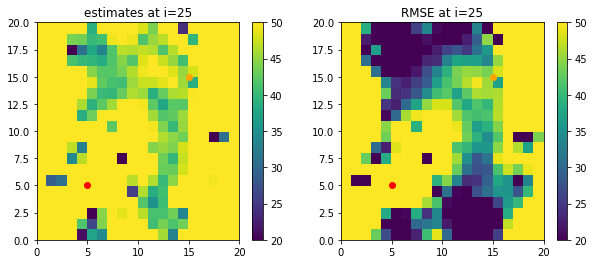

Total RMSE: 21024.082097063747


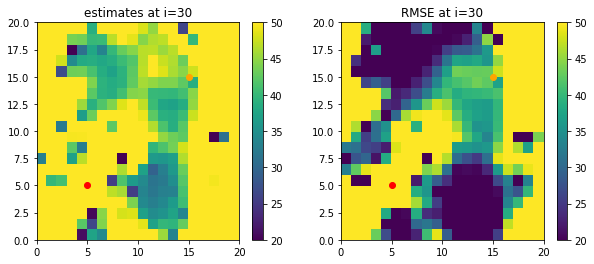

Total RMSE: 17276.020696305655


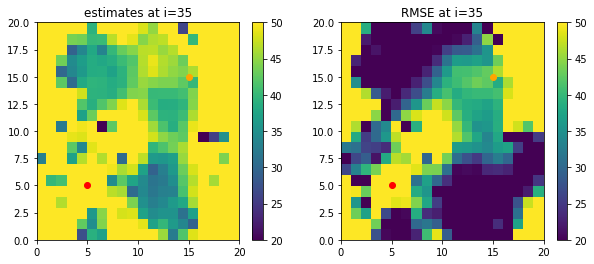

Total RMSE: 15328.393186724266


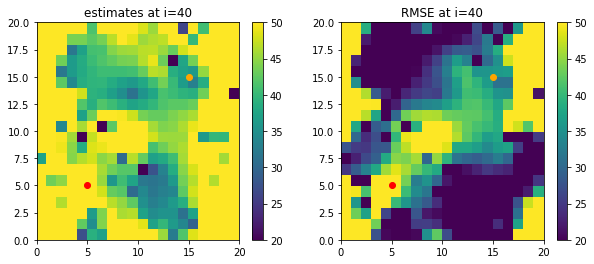

Total RMSE: 13436.071404540937


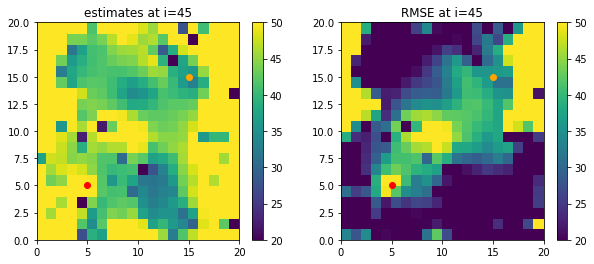

Total RMSE: 12025.576116340248


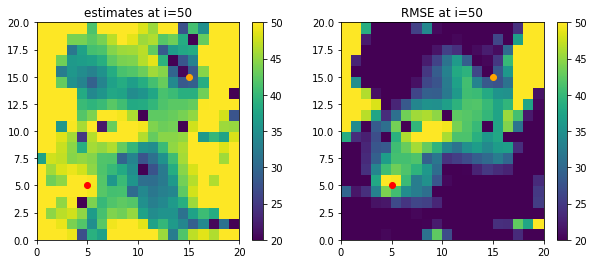

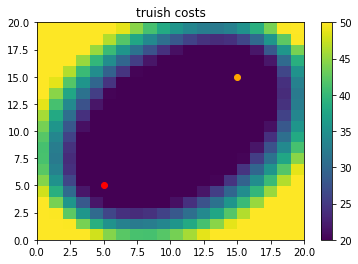

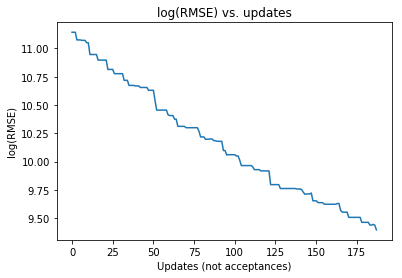

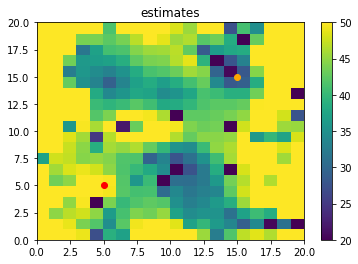

In [17]:
field = big_tester(size, 51, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=5)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

DEEPER!

### Even even higher resolution at the beginning of training

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Total RMSE: 64386.368998916994


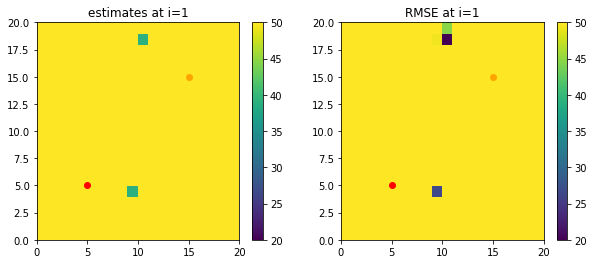

Total RMSE: 62205.508195138376


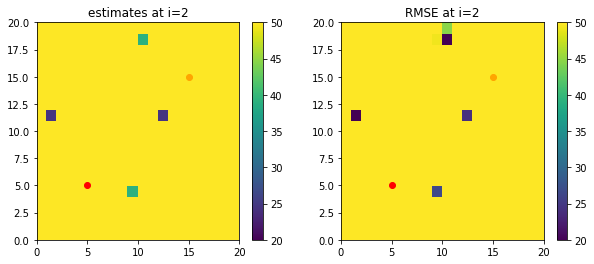

Total RMSE: 57406.74674962195


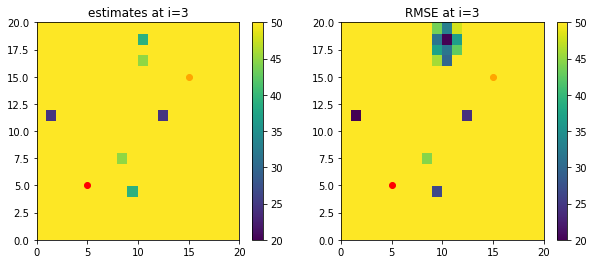

Total RMSE: 57177.76957595075


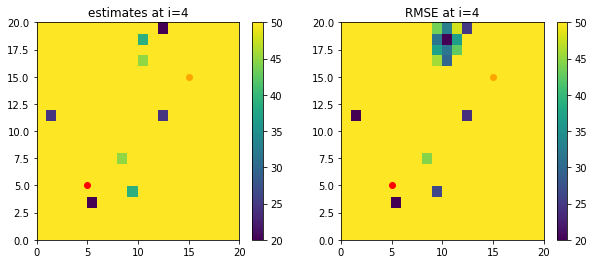

Total RMSE: 56984.41665891429


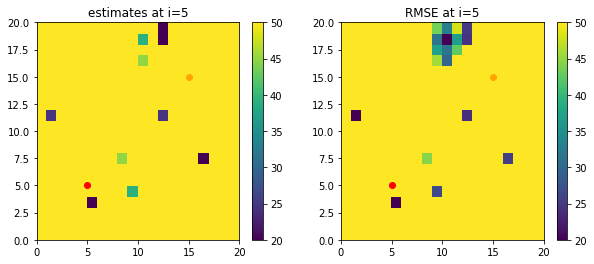

Total RMSE: 52477.99978129796


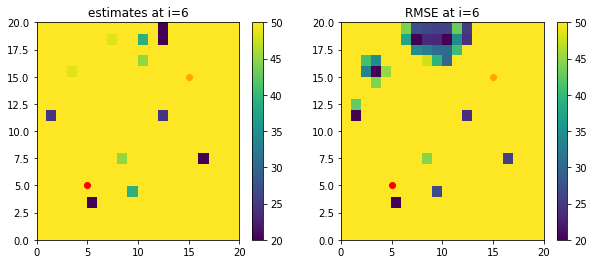

Total RMSE: 52256.48210426831


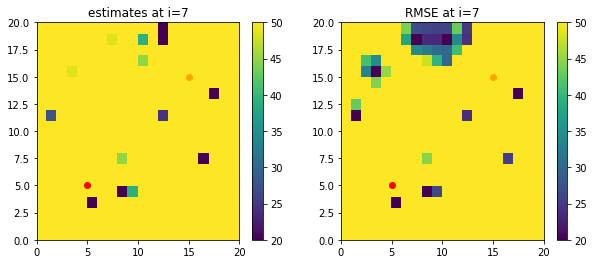

Total RMSE: 52252.30989204129


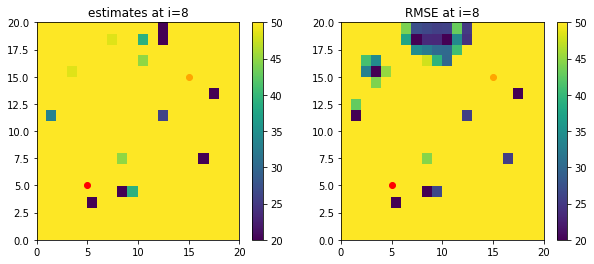

Total RMSE: 47942.426467922836


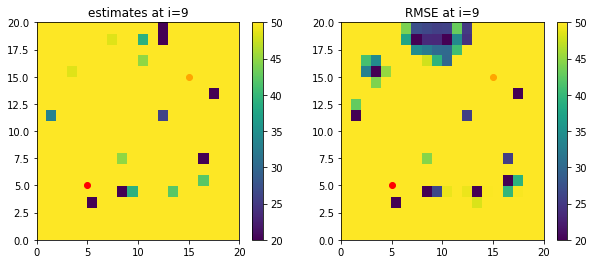

Total RMSE: 47658.36575984054


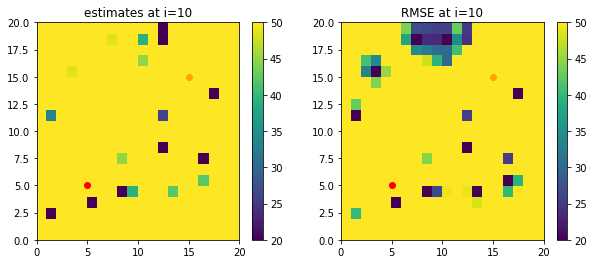

Total RMSE: 43700.30419991941


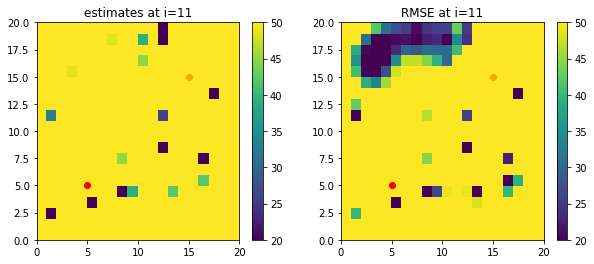

Total RMSE: 42919.021737292496


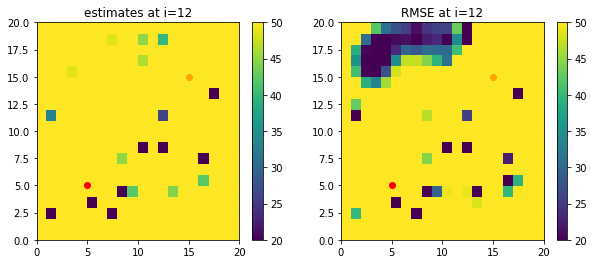

Total RMSE: 41926.97515931169


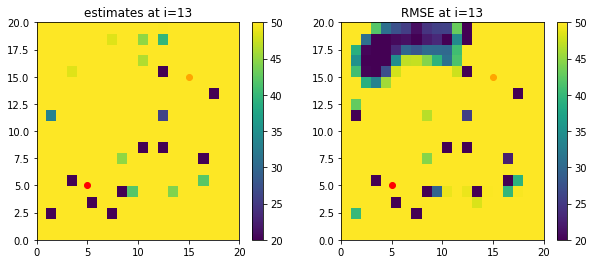

Total RMSE: 41715.802189211056


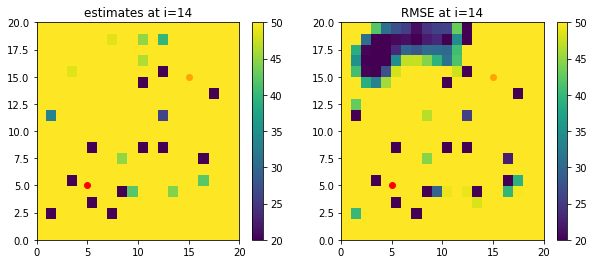

Total RMSE: 39359.663591364515


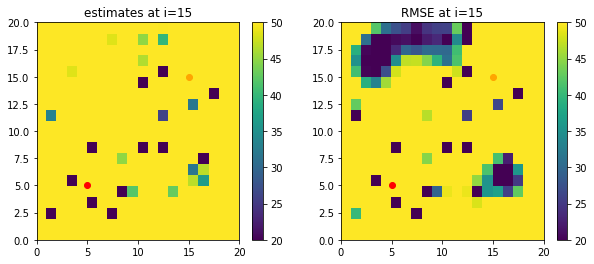

Total RMSE: 39324.281512646994


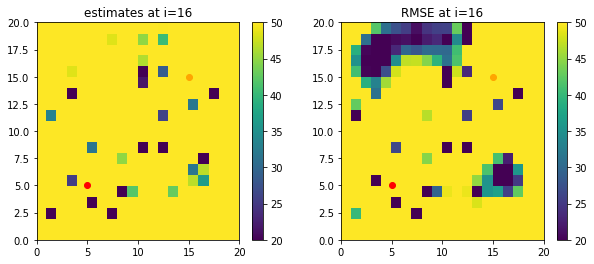

Total RMSE: 37387.97693838332


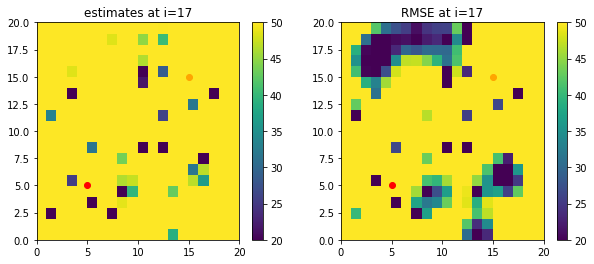

Total RMSE: 37198.675633554


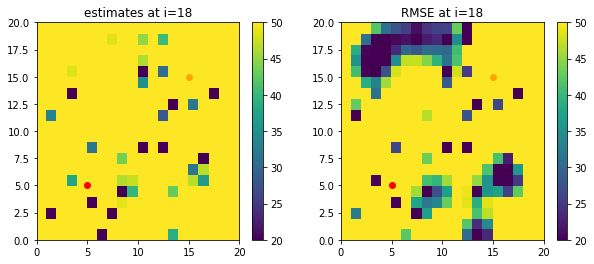

Total RMSE: 36902.23578623691


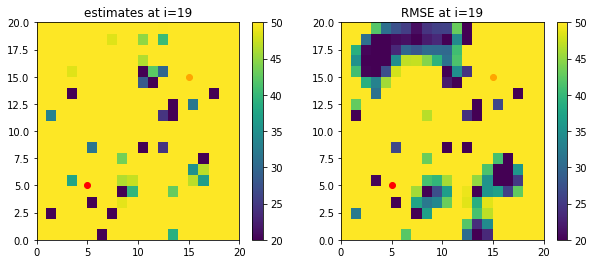

Total RMSE: 36083.1735053875


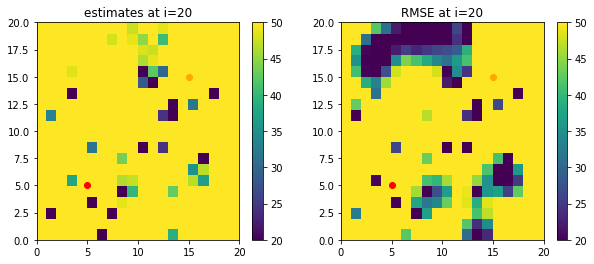

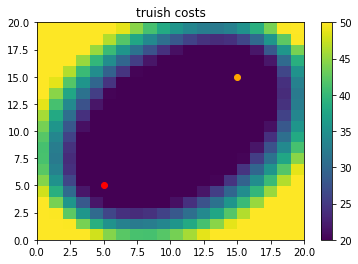

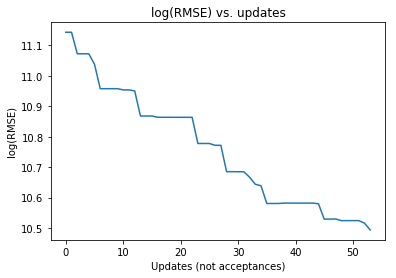

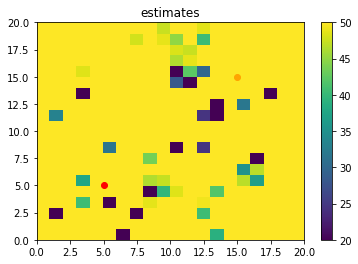

In [18]:
field = big_tester(size, 21, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=1)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

## Try less sensitive weight functions

Estimates appear to be too bouncy. Freeze estimates sooner.

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


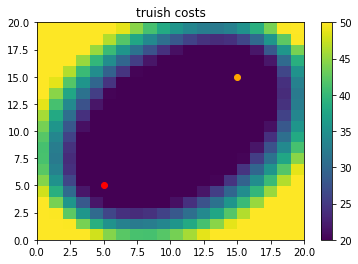

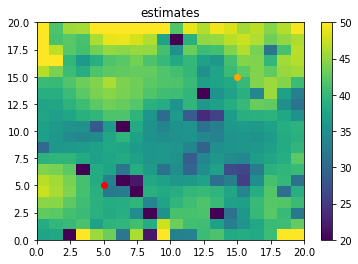

In [19]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 10001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

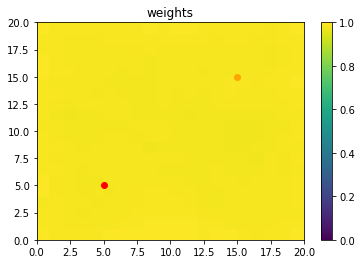

In [20]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

The entire field's estimates coalesced into basically the same value, but if you squint you can see that there is some variance in a way that we'd expect.

## Fewer iterations?

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


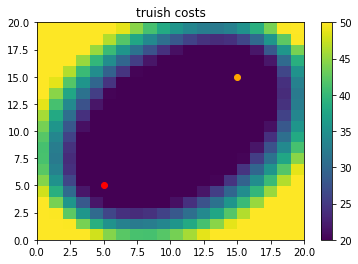

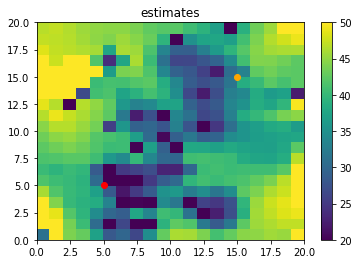

In [21]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

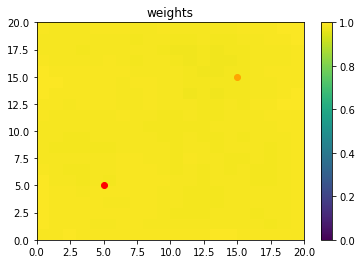

In [22]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

There just isn't enough variation in our cost estimates.

## Fewer rejected requests before reset?

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


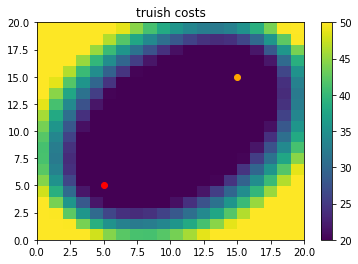

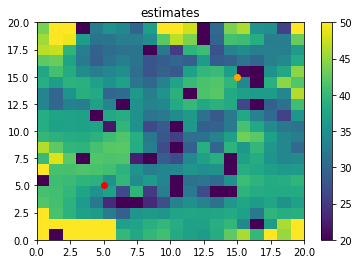

In [23]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 2, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

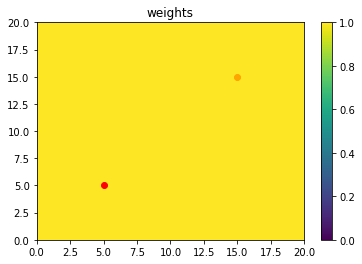

In [24]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

The cost estimates don't look right. What about tossing the reset counter entirely?

## No consecutive matches

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


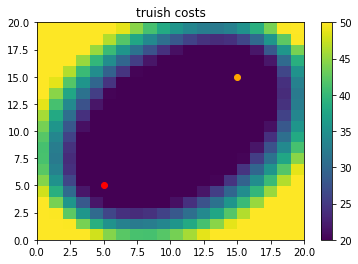

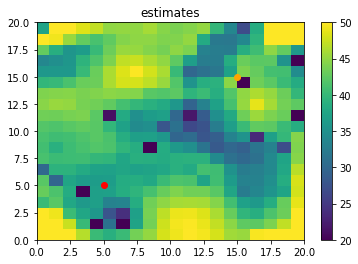

In [25]:
# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .001*(1-d) )) )

field = big_tester(size, 10001, 0, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50)
plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)

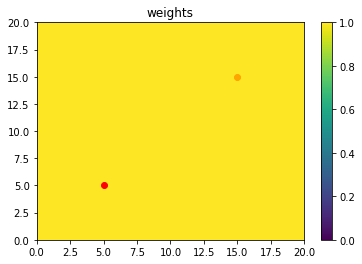

In [26]:
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

Estimate field still doesn't vary enough/as expected.

## Larger field with smaller things

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


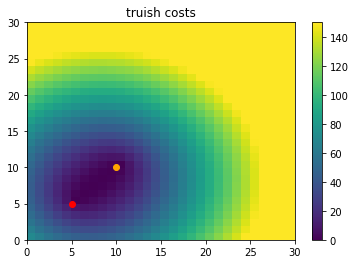

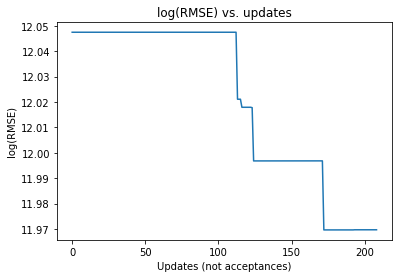

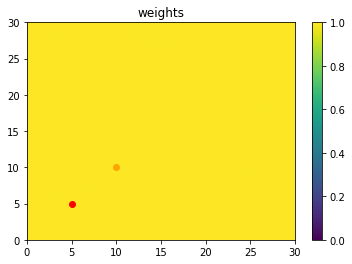

In [27]:
size = 30

# set original params
ogorg = (10,10)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .01*(1-d) )) )

# colorbar minmax
vmin = 0
vmax = 150

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/8, size/4), weight_fcn, weight_fcn_aggressive, vmin=vmin, vmax=vmax, log=False, progress_plot_interval=100)
# plot_field(field, og=ogorg, dt=depot, vmin=vmin, vmax=vmax)
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

Not sure about this one. I had to narrow the colorbar window a lot to get it to look reasonable, but at least it finally looks like what we'd expect.

## Don't update weights when observing expected behavior

Tweak weight function accordingly.

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Total RMSE: 14159.98671475178


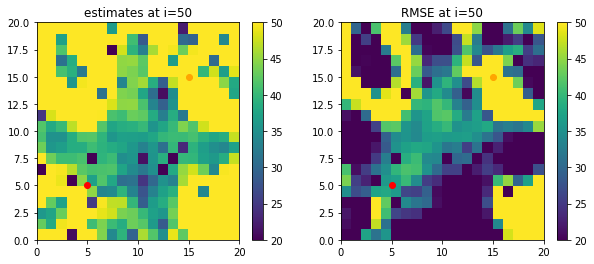

Total RMSE: 7560.445892514606


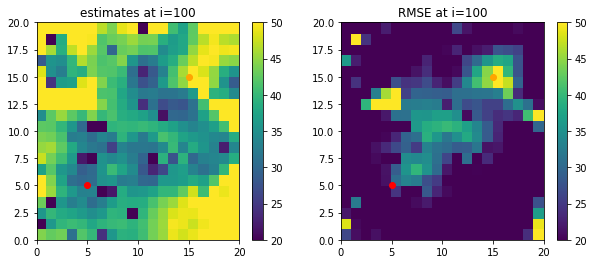

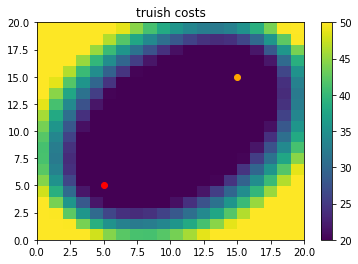

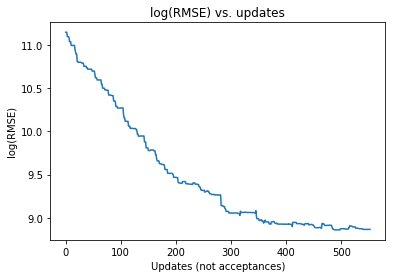

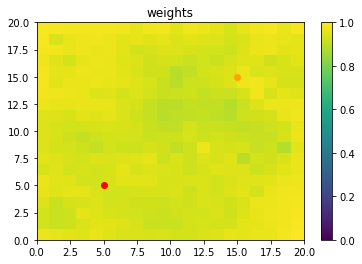

In [28]:
size = 20

# set original params
ogorg = (15,15)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .01*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .1*(1-d) )) )

field = big_tester(size, 501, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=50, progress_plot_interval=50, update_on_expected_behavior=False)
# plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

/home/carlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


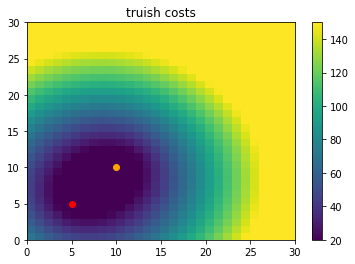

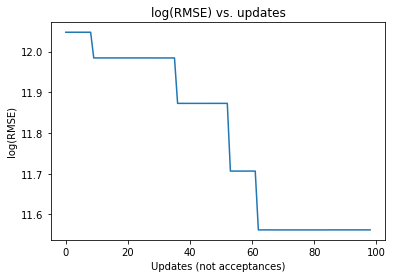

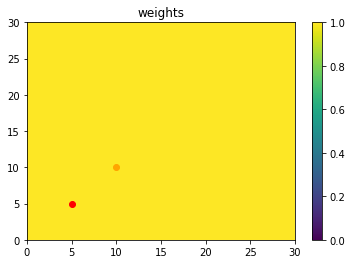

In [29]:
size = 30

# set original params
ogorg = (10,10)
depot = (5,5)

# weight functions
weight_fcn = (lambda w,d: w/ (1 + ( .001*(1-d) )) )
weight_fcn_aggressive = (lambda w,d: w/ (1 + ( .1*(1-d) )) )

field = big_tester(size, 1001, 5, ogorg, depot, (-1*size/4, size/2), weight_fcn, weight_fcn_aggressive, vmin=20, vmax=150, progress_plot_interval=100, update_on_expected_behavior=False)
# plot_field(field, og=ogorg, dt=depot, vmin=20, vmax=50)
plot_field(field, estimates=False, og=ogorg, dt=depot, vmin=0, vmax=1)

# Conclusions

No idea.